In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [250]:
df = pd.read_csv("mobilepricerangeclass.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.20,0,1,0,7,0.60,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.50,1,0,1,53,0.70,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.50,1,2,1,41,0.90,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.50,0,0,0,10,0.80,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.20,0,13,1,44,0.60,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [251]:
print(df.duplicated().sum())
print(df.isna().sum())

0
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64


In [252]:
# Get the sorted correlation matrix for price range only
# Which variables are most important for price range
corr_matrix =df.corr()['price_range']
corr_matrix.sort_values(ascending=False)

price_range      1.00
ram              0.92
battery_power    0.20
px_width         0.17
px_height        0.15
int_memory       0.04
sc_w             0.04
pc               0.03
three_g          0.02
sc_h             0.02
fc               0.02
talk_time        0.02
blue             0.02
wifi             0.02
dual_sim         0.02
four_g           0.01
n_cores          0.00
m_dep            0.00
clock_speed     -0.01
mobile_wt       -0.03
touch_screen    -0.03
Name: price_range, dtype: float64

In [253]:
# suggestion for dropping some not-so-important columns
# regarding price range
# Correlations and SelectKBest-score were helpful in confirming the less useful columns
removables = ["touch_screen", "mobile_wt", "clock_speed", "m_dep", "three_g", "four_g", "blue", "wifi"]


In [254]:
# let's drop the unnecessary columns from the dataframe
df = df.drop(removables, axis=1)
df.head()

,battery_power,dual_sim,fc,int_memory,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range
0,842,0,1,7,2,2,20,756,2549,9,7,19,1
1,1021,1,0,53,3,6,905,1988,2631,17,3,7,2
2,563,1,2,41,5,6,1263,1716,2603,11,2,9,2
3,615,0,0,10,6,9,1216,1786,2769,16,8,11,2
4,1821,0,13,44,2,14,1208,1212,1411,8,2,15,1


In [255]:
 # replace the target out class names with more human understandable versions
df['price_range'] = df['price_range'].replace({0: "1: Cheap", 1: "2: Avg-", 2: "3: Avg+", 3: "4: Expensive"})

<b>X and y variables, notice that we have to encode the target variable</b>

In [256]:
# everything else except the target variable
X = df.drop("price_range", axis=1)

# have only the target variable here (dependent variable)
y = df['price_range']

# Normalization
# X_mm = MinMaxScaler().fit_transform(X)

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [257]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
8,ram,931267.52
6,px_height,17363.57
0,battery_power,14129.87
7,px_width,9810.59
3,int_memory,89.84
10,sc_w,16.48
11,talk_time,13.24
2,fc,10.14
9,sc_h,9.61
5,pc,9.19


<b>Build the neural network</b>

In [258]:
# As always, train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [259]:
categories = list(np.unique(df['price_range']))
print(categories)

# note: this only works if the categories are ordinal integers
# if you wish to keep the order of the text labels, you might want to do
# something like this before so that the number is also carried with
# the rest of the code
# df['price_range'] = df['price_range'].replace({0: "1: Cheap", 1: "2: Avg-", 2: "3: Avg+", 3: "4: Expensive"})

['1: Cheap', '2: Avg-', '3: Avg+', '4: Expensive']


In [260]:
X.columns

Index(['battery_power', 'dual_sim', 'fc', 'int_memory', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'],
      dtype='object')

In [261]:
# First version of the neural network
# No optimisations, probably won't work well
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", input_shape=(len(X.columns),)),
        layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l1(l=0.1)),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 12)                48        
 Normalization)                                                  
                                                                 
 dense_40 (Dense)            (None, 16)                208       
                                                                 
 dense_41 (Dense)            (None, 32)                544       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_42 (Dense)            (None, 8)                 264       
                                                                 
 dense_43 (Dense)            (None, 4)                 36        
                                                     

In [262]:
# Epochs can be adjusted
model.fit(x=X_train, y=y_train, epochs=800, validation_data=(X_val, y_val))

Epoch 1/800


44/44 [==============================] - 2s 9ms/step - loss: 9.6042 - accuracy: 0.2714 - val_loss: 8.6196 - val_accuracy: 0.2533
Epoch 2/800
44/44 [==============================] - 0s 4ms/step - loss: 7.5939 - accuracy: 0.3007 - val_loss: 6.7215 - val_accuracy: 0.3000
Epoch 3/800
44/44 [==============================] - 0s 4ms/step - loss: 5.9082 - accuracy: 0.3529 - val_loss: 5.1610 - val_accuracy: 0.3267
Epoch 4/800
44/44 [==============================] - 0s 3ms/step - loss: 4.4966 - accuracy: 0.3914 - val_loss: 3.8570 - val_accuracy: 0.3900
Epoch 5/800
44/44 [==============================] - 0s 4ms/step - loss: 3.3168 - accuracy: 0.4500 - val_loss: 2.7804 - val_accuracy: 0.5633
Epoch 6/800
44/44 [==============================] - 0s 4ms/step - loss: 2.3710 - accuracy: 0.5050 - val_loss: 1.9445 - val_accuracy: 0.5700
Epoch 7/800
44/44 [==============================] - 0s 3ms/step - loss: 1.6973 - accuracy: 0.5179 - val_loss: 1.4170 - val_accuracy: 0.6200
Epoch 8/800
44/44 [======

<Axes: >

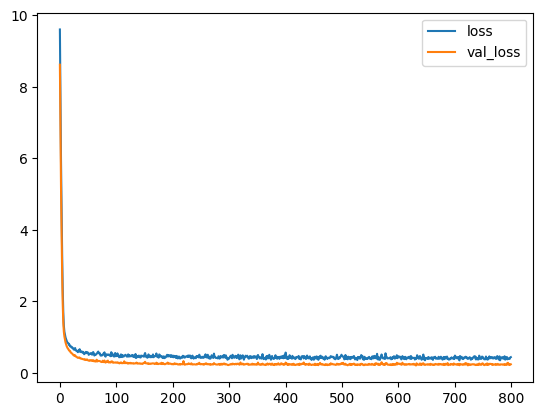

In [263]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

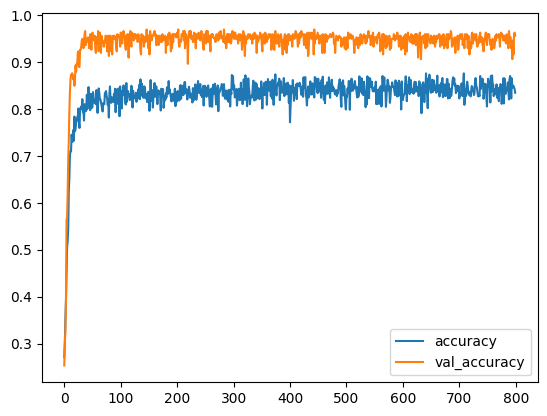

In [264]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [265]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.2575758099555969, 0.9599999785423279]

Train data evaluation:
[0.24592089653015137, 0.947857141494751]


In [266]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

10/10 [==============================] - 0s 3ms/step


<Axes: >

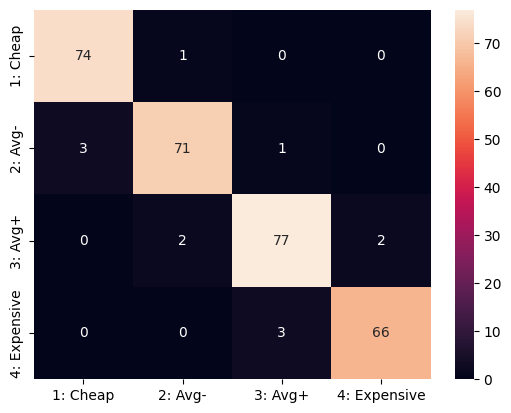

In [267]:
# Original heatmap without label names
# sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

# you can also use the actual names for the categories
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

In [268]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

    1: Cheap       0.96      0.99      0.97        75
     2: Avg-       0.96      0.95      0.95        75
     3: Avg+       0.95      0.95      0.95        81
4: Expensive       0.97      0.96      0.96        69

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300


Model overall accuracy: 96.00%


In [269]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary classification, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

 1/63 [..............................] - ETA: 1s

63/63 [==============================] - 0s 2ms/step


0.997797

In [272]:
# Make a new test prediction

tester_row = {
    'battery_power': 1000, 
    'dual_sim': 0 ,
    'fc': 4, 
    'int_memory': 4, 
    'n_cores': 1, 
    'pc': 4,
    'px_height': 900,
    'px_width': 1200, 
    'ram': 1024, 
    'sc_h': 7, 
    'sc_w': 4, 
    'talk_time': 12
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
print(result.round(3))

result_index = np.argmax(result)
print(result_index)

# print the actual name with this index
result_text = categories[result_index]

# print the result
print(f"Predicted price range: {result_text}")

1/1 [==============================] - 0s 36ms/step
[0.774 0.226 0.    0.   ]
0
Predicted price range: 1: Cheap


In [ ]:
model.save("mobilephoneprice.keras")